In [363]:
# libraries
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import os
import datetime
from IPython import display

In [364]:
from sklearn.metrics import mean_squared_error

In [365]:
tf.__version__

'2.8.0'

In [366]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [367]:
# Building a complex and powerful Recurrent Neural Network (RNN).
# It will be able to predict profitable trading signals.

In [368]:
# Using a Recurrent Neural Network that allows forward propagation and backward propagation. Only RNN allows backward propagation aka feedback connection, which is important as the model self-adjusts its nuerons weights and bias after it has predicted the value and compared it to the actual value and hence it knows what the loss function value or RMSE is, so that it knows what weights to adjust to decrease it.
# Example of RNN model is LSTM model which is designed for Time Series Analysis

In [369]:
# Build stock/crypto price prediction for next day, next 3 days (72 hours), next 7 days (daily prices), next month (daily prices).

In [370]:
# Gathering the data.
# Trying the Bitcoin BTC first.
# Downloading Last 5 years of data.
btc_data = pdr.get_data_yahoo(["BTC-USD"], start=datetime.datetime(2015, 12, 30), end=datetime.datetime.now())

In [371]:
btc_data

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2015-12-30,426.619995,426.619995,434.386993,422.084015,433.299988,46889400
2015-12-31,430.566986,430.566986,432.920990,418.734985,425.875000,45996600
2016-01-01,434.334015,434.334015,436.246002,427.515015,430.721008,36278900
2016-01-02,433.437988,433.437988,436.062012,431.869995,434.622009,30096600
2016-01-03,430.010986,430.010986,433.743011,424.705994,433.578003,39633800
...,...,...,...,...,...,...
2022-05-17,30425.857422,30425.857422,30694.490234,29570.302734,29862.408203,29101473475
2022-05-18,28720.271484,28720.271484,30618.716797,28720.271484,30424.478516,31285268319


In [372]:
# Converting multindex columns to single level.
btc_data.columns = [x[0] for x in btc_data.columns]

In [373]:
# Time Series data
ts_copy = btc_data.copy()

In [374]:
ts_copy = pd.Series(ts_copy.index)

In [375]:
ts_copy = pd.DataFrame(ts_copy)

In [376]:
# Explore data.
# Find Outliers and Empty values
# Empty values in any() method are considered np.NaN, 0 or False or "" empty string.
btc_data[~btc_data.any(axis=1)]

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,


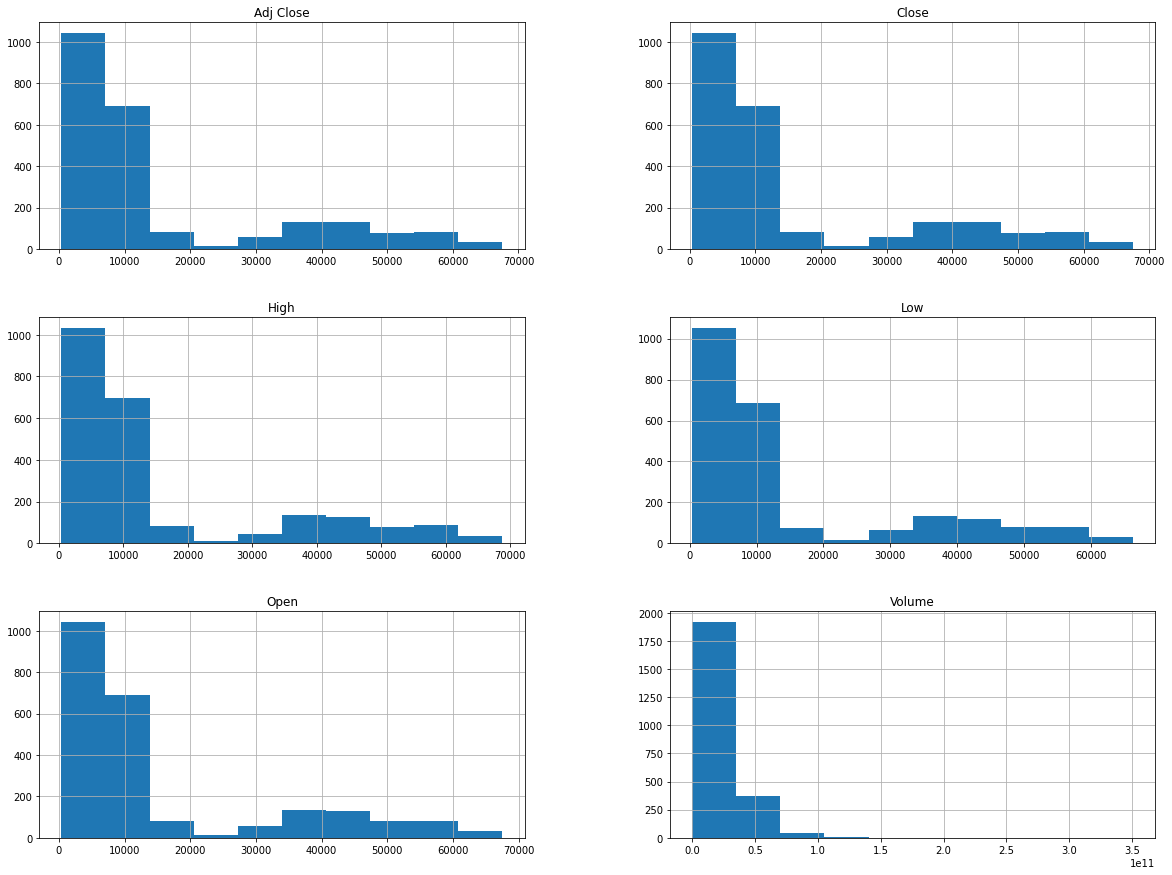

In [377]:
# Lets see the data distribution
btc_data.hist(figsize=(20, 15))
plt.show()

In [378]:
# Using Data Windowing to create labels for your inputted window
# The model will make set of predictions based on a window of consecutive samples from the price data
# The width (number of time steps) of the input and label windows.
# The time offset between them.
# Which features are used as inputs, labels, or both.
# Time step (1 day)

# in days
input_width = 3
label_width = 3

def sliding_window(input_width, label_width, df):
    indices = np.arange(len(df))
    column_length = len(df.columns)
    
    y_labels_df = df[['Date', 'Close']]

    store_inp_data = []
    store_labl_data = []

    for idx in indices[::input_width + label_width]:
        store_inp_data.append(df[idx: idx+input_width].values)
        store_labl_data.append(y_labels_df[idx+input_width: idx+input_width+label_width].values)
    
    return store_inp_data, store_labl_data


In [379]:
input_df = btc_data.copy()

In [380]:
input_df_reset = input_df.reset_index()

In [381]:
storage = []

In [382]:
str_random = input_df_reset[0:5].values

In [383]:
storage.append(str_random)

In [384]:
np.array(storage)

array([[[Timestamp('2015-12-30 00:00:00'), 426.6199951171875,
         426.6199951171875, 434.3869934082031, 422.0840148925781,
         433.29998779296875, 46889400],
        [Timestamp('2015-12-31 00:00:00'), 430.5669860839844,
         430.5669860839844, 432.9209899902344, 418.7349853515625,
         425.875, 45996600],
        [Timestamp('2016-01-01 00:00:00'), 434.3340148925781,
         434.3340148925781, 436.2460021972656, 427.5150146484375,
         430.72100830078125, 36278900],
        [Timestamp('2016-01-02 00:00:00'), 433.43798828125,
         433.43798828125, 436.06201171875, 431.8699951171875,
         434.62200927734375, 30096600],
        [Timestamp('2016-01-03 00:00:00'), 430.010986328125,
         430.010986328125, 433.7430114746094, 424.70599365234375,
         433.5780029296875, 39633800]]], dtype=object)

In [385]:
X_window_data, y_window_data = sliding_window(input_width, label_width, input_df_reset)

In [386]:
# I am excluding last element in the array, as otherwise there is a bug in conversion to nmpy array from list.
X_window_data_reshaped = np.array(X_window_data[0:-1])
y_window_data_reshaped = np.array(y_window_data[0:-1])

In [387]:
# Train Test Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_window_data_reshaped, y_window_data_reshaped, test_size=0.2, shuffle=False)

In [388]:
# Splitting further into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, shuffle=False)

In [389]:
X_train.shape

(233, 3, 7)

In [390]:
y_train.shape

(233, 3, 2)

In [391]:
# Storing respective time data for each dataframe
X_train_full_time_index = X_train_full[:,:,0]

In [392]:
# Getting rid of time data points
X_test = X_test[:,:,1:]
X_train = X_train[:,:,1:]
X_valid = X_valid[:,:,1:]

In [393]:
# Getting rid of time data points
y_train = y_train[:,:,1:]
y_valid = y_valid[:,:,1:]
y_test = y_test[:,:,1:]

In [394]:
# Reshaping data so that it can be inputted in requried 2d format to be transformed and scaled.
X_test_reshaped = X_test.reshape(-1, 18)
X_train_reshaped = X_train.reshape(-1,18)
X_valid_reshaped = X_valid.reshape(-1, 18)

In [444]:
y_train_reshaped = y_train.reshape(-1, 3)
y_valid_reshaped = y_valid.reshape(-1,3)
y_test_reshaped = y_test.reshape(-1,3)

In [445]:
# Scaling the data. Specifically is Standardizing the data, because RNN are very sensitive to outliers and need data to be scaled to same scales.
scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")

In [446]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("std_scaler", StandardScaler()),
])

In [447]:
X_train_scaled = num_pipeline.fit_transform(X_train_reshaped)
X_valid_scaled = num_pipeline.transform(X_valid_reshaped)
X_test_scaled = num_pipeline.transform(X_test_reshaped)

In [448]:
y_train_scaled = num_pipeline.fit_transform(y_train_reshaped)
y_valid_scaled = num_pipeline.transform(y_valid_reshaped)
y_test_scaled = num_pipeline.transform(y_test_reshaped)

In [449]:
# reshaping the X_inputs back into 3 dimensional ndarray
X_test_3d = X_test_scaled.reshape(-1, 3, 6)
X_train_3d = X_train_scaled.reshape(-1, 3, 6)
X_valid_3d = X_valid_scaled.reshape(-1, 3, 6)

In [450]:
y_train_3d = y_train_scaled.reshape(-1,3,1)
y_valid_3d = y_valid_scaled.reshape(-1,3,1)
y_test_3d = y_test_scaled.reshape(-1,3,1)

In [454]:
# You need to make LSTM(Number) match your [batch, time_step, features] batch number.

OUT_STEPS = X_train_3d.shape[1]
num_features = 1

input_shape = X_train_3d.shape

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time_steps, features] => [batch, lstm_units]
    # If return_sequences=False, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:
    # If return_sequences=True, allows Training a model on multiple time steps simultaneously.
    tf.keras.layers.LSTM(input_shape[0], return_sequences=True),
    # Shape => [batch, out_steps*features]
#     tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    
    # At the end we want to display just 1 feautre = 1 label.
    # Hence such output shape => [batch, time_steps, feature(1)]
    tf.keras.layers.Dense(units=1),
])

In [455]:
multi_lstm_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [459]:
multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

In [460]:
X_train_3d_1 = X_train_3d.astype("float32")
y_train_3d_1 = y_train_3d.astype("float32")

In [461]:
history = multi_lstm_model.fit(X_train_3d_1, y_train_3d_1, epochs=20, validation_data=(X_valid_3d, y_valid_3d))

Epoch 1/20
8/8 [==============================] - 2s 48ms/step - loss: 0.0676 - mean_absolute_error: 0.1821 - val_loss: 0.7771 - val_mean_absolute_error: 0.4599
Epoch 2/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0350 - mean_absolute_error: 0.1260 - val_loss: 1.0342 - val_mean_absolute_error: 0.5236
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0260 - mean_absolute_error: 0.1012 - val_loss: 0.8807 - val_mean_absolute_error: 0.4565
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - mean_absolute_error: 0.0927 - val_loss: 0.6842 - val_mean_absolute_error: 0.4039
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - mean_absolute_error: 0.1032 - val_loss: 0.8098 - val_mean_absolute_error: 0.4412
Epoch 6/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0245 - mean_absolute_error: 0.0906 - val_loss: 1.2387 - val_mean_absolute_error: 0.5311
Epoch 7/20
8/8 [=======================

In [462]:
# Testing the data on the test set and storing the rmse error
# After that plotting the actual labels vs predicted data.
mse_test = multi_lstm_model.evaluate(X_test_3d, y_test_3d)

3/3 [==============================] - 0s 3ms/step - loss: 26.1329 - mean_absolute_error: 4.7173


In [464]:
y_predicted = multi_lstm_model.predict(X_test_3d)

In [466]:
y_predicted_reshape = y_predicted.reshape(-1,3)
y_test_reshape = y_test_3d.reshape(-1,3)

In [467]:
y_predicted_inversed = num_pipeline.inverse_transform(y_predicted_reshape)

In [469]:
y_test_labels_inversed = num_pipeline.inverse_transform(y_test_reshape)

In [476]:
y_predicted_rsh = y_predicted_inversed.reshape(-1)
y_test_labels_rsh = y_test_labels_inversed.reshape(-1)

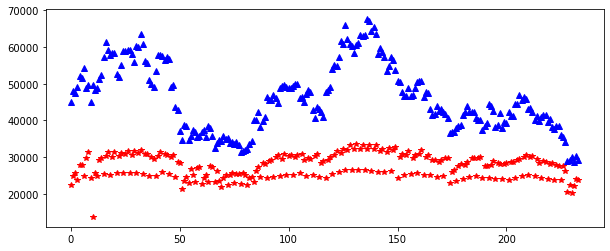

In [481]:
# Plotting graph of labels and predicted labels.
plt.figure(figsize=(10,4))
plt.plot(y_predicted_rsh, 'r*', label="predicted")
plt.plot(y_test_labels_rsh, "b^", label="actual")
plt.show()